## Part 3: Parallel Programming
    

Time to break out the big guns. If your code is still taking too long and you've picked all the low-hanging fruit, it's time to think about parallel programming. 

Modern computers get their speed from having multiple cores, from the four or so in your laptop, to thousands in a supercomputer. But your code doesn't usually 'know' how to take advantage of these resources by itself -- you have to figure out how to break up your code into pieces that can run on different cores at the same time.

This can range from easy to exceedingly complicated depending on task requirements and scale. But often you can get by with some simple tricks. 

## Parallel Programming Approaches

* Embarassingly Parallel
* Multicore
* Multinode


### Embarassingly Parallel

<center><img src="embarassing.png" width="40%" ></center>

Embarassing because *embarrassingly* easy to make this run in parallel.

Embarassingly parallel is where each unit of computation is completely independent of the others. For instance, if you're batch processing a set of images and you only care about one image at a time.

This is the easiest case to deal with! Perhaps you have a bunch of files to process? Or you need to run a model across a range of a range of parameters, and each run is independent? We can run one job per computer, or perhaps a couple per computer (but isolated from one other) to get the speed we need.

#### Embarassingly Parallel in Python

_Simplest_: Just run multiple Python instances at the same time (e.g. one per dataset).

```
python my_code.py data_1.dat &
python my_code.py data_2.dat &
python my_code.py data_3.dat &
python my_code.py data_4.dat &
```


This is the easiest approach -- just run multiple copies of your program at once with different inputs. The operating system will distribute these over the multiple cores of your computer, but keep in mind that if you create more instances than cores in your computer (typically 2-4) you mightn't see an additional speedup. Memory also has to be shared between the different processes. 

Embarassingly parallel includes not just running multiple jobs on the same computer, but also across multiple computers. We'll talk about how to do this on a supercomputer later.

(The '&' in the above example is unix for 'run in background'... we could achieve the same thing by running in multiple terminal tabs, for instance.)


#### Embarassingly Parallel in Python

Little More Advanced: Use the Python `multiprocessing` library.


In [ ]:
from multiprocessing import Pool

def process_file(filename):
    data = open(filename).read()
    output = my_analysis(data)
    open('output.dat', 'w').write(output)

pool = Pool(processes=8)
input_files = ['data_1.dat', '...', 'data_8.dat']
pool.map(process_file, input_files)

This code will spin up 8 processes, run `my_analysis` on each and save the results.

### Multicore

<center><img src="multicore.png" width="20%" ></center>

Multicore is the next step up. This is where your program shares the load across the different cores (or CPUs) within your computer. Typically a program will only run on one core at a time, but by splitting it up into different processes or threads we can share the load. Your desktop computer probably has at least four cores, and a heavy-duty server might have 12 or more (even up to 64 or more in some specialised circumstances).

Communication is all within the same computer and so communication is fast, and data can be readily shared between processes through memory.

#### Multicore in Python

Let's use `multiprocessing` again

In [ ]:
from multiprocessing import Pool

def process_file(filename):
    data = open(filename).read()
    return my_analysis(data) # Return single datapoint

pool = Pool(processes=8)
input_files = ['data_1.dat', '...', 'data_8.dat']

# This line runs in parallel, returning an array from each process
intermediate_results = pool.map(process_file, input_files) 

# This line integrates results, which is a serial process
# (unlike embarassingly parallel)
final_result = my_summary_analysis(intermediate_results)

### Multinode

<center><img src="multinode.png" width="35%" ></center>

Multinode is the most advanced approach, but also the only way to scale up once you've used up all the resources in a single PC for a given job. Like multinode, we make use of all the cores in a given computer, but we also share the load across other computers, typically over a high-speed network. This is the essence of how a traditional supercomputer works, which we'll talk about later.

Since we now have to communicate beyond a single PC, we can't use shared memory to communicate, instead we pass messages over a network, typically using a protocol called MPI -- (M)essage (P)assing (I)nterface. The only thing to be careful of is that sending messages over the network is usually slower than sending between cores, so we have to structure our problems carefully.

There are some really important applications of multinode high performance computing, particularly complex physics simulations, and so it's handy to keep this in the back of your mind. But I'd say 90% of you only have to worry embarassingly parallel and multicore techniques to get your work done satisfactorily. 

Let's now talk about how you apply this in Python.

#### Multinode in Python

* MPI4Py - (M)essage (P)assing (I)nterface for Python (Low Level Interface)
* iPython Parallel - Like the `multiprocessing` library (Mid Level Interface)
* Dask - NumPy arrays and Pandas dataframes (High Level Interface)

(But suitable for multicore & embarassingly parallel too!)

#### MPI4Py

In [ ]:
%%writefile mpi_example.py

import random
from mpi4py import MPI

def monte_carlo_pi_part(n):
    count = 0
    for i in range(n):
        x = random.random()
        y = random.random()

        if x * x + y * y <= 1:
            count += 1
    return count


In [ ]:
%%writefile -a mpi_example.py

def master():
    points_per_node = int(n / (size - 1))

    for worker in range(1, size):
        comm.send(points_per_node, dest=worker)

    received_processes = 0
    count = 0

    # Await results
    while received_processes < (size - 1):
        count += comm.recv(source=MPI.ANY_SOURCE)
        received_processes += 1

    print('Estimated value of Pi: %f ' % (count / (n * 1.0) * 4))

def slave():
    points_to_calculate = comm.recv(source=0)
    count = monte_carlo_pi_part(points_to_calculate)
    comm.send(count, dest=0)


In [ ]:
%%writefile -a mpi_example.py

# Who am I?
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Number of points to simulate (10 million)
n = 10000000

print('My rank: %d' % rank)

if rank == 0:
    # I'm the master, tell other nodes to do.
    print('Simulate %d million points across %d workers' % (n / 1e6, size))
    master()
else:
    # I'm the slave... await instructions then shutdown.
    slave()

In [ ]:
!mpirun -np 4 python mpi_example.py

MPI (Message Passing Interface) is a very common framework for large-scale scientific computing, based on the idea of passing messages between different workers to come up with a solution. You can group workers, and communicate between them in various patterns.

MPI4Py provides a simple interface to MPI. In this example we are calculating Pi using a Monte Carlo technique (taking lots of random samples to find an answer). Each worker is assigned a rank, which determines its identity. One worker passes a commands out, awaits the results and does a final tally, while the others await a command, do some calculations and then send their partial result back when done.

#### iPython Parallel


http://ipyparallel.readthedocs.io

* Interface for controlling multiple instances of iPython
* Those instances could be local or remote (allowing multinode work).
* _Focused on interactive work (like this notebook!)_


In [17]:
# In terminal run: ipcluster start -n 4
# This will give us four workers.

# Connect
import ipyparallel as ipp
import time
c = ipp.Client()

# Show IDs of each worker
c.ids

[0, 1, 2, 3]

In [20]:
# Fun a function across an array.
# Like 'map' in multiprocessing libraray, but can be across multiple computers.
c[:].map_sync(lambda x: x*x, range(10))

NoEnginesRegistered: Can't build targets without any engines

In [19]:
# Shutdown again
c.shutdown()

Here's a quick example. We start a cluster of IPython workers, locally here, but they could be spread across hundreds of machines. We then run a simple function, multiplying 0 to 9 by itself. Each worker gets allocated a chunk of the array to calculate automatically.

This is really an 'embarassingly parallel' example... but there are many other patterns possible as well. 

To reiterate, we could do the exact same thing using the `multiprocessing` library instead for this example... the advantage is that we can scale this beyond a single computer if need be.

#### Dask
* Provides high-level Pandas- and NumPy-like interfaces
* ...provides low level interfaces as well if needed.
* Can run on single computer, or across a cluster.
* Also handy for interactive work.

MPI is quite language-agnostic; you tend to work the same whether you're using C, Fortran or Python.

Dask is different. It is Python-specific, and allows you to run calculations via a variety of interfaces, including NumPy and Pandas, across a cluster (or just across multiple cores of your own computer). It borrows some ideas from Big Data frameworks like Spark. 

It can be used in many different ways, but I'm going to show how you might work with a large CSV file. This can be scaled to files that are a hundred times bigger -- things that would barely fit on a local harddrive, and certainly not fit in RAM on a normal computer!

Dask has some similarities with iPython Parallel. Dask is more sophisticated, but not yet as mature. If you're interested in comparing the two, this is discussed at: http://distributed.readthedocs.io/en/latest/related-work.html#id1

In [12]:
# This is a part of the NYC Taxi Trip dataset, and it's 1.8GB for just one month worth!
!ls -lh /Users/davidperry/yellow_tripdata_2015-01.csv


# In my terminal, I'll run 'dask-scheduler --host 127.0.0.1:8786' and 'dask-worker 127.0.0.1:8786 --nprocs 4' 
# across two tabs so I can monitor things.

# Then open http://127.0.0.1:8787/status in my browser so we can monitor what's happening.

-rw-r--r--  1 davidperry  staff   1.8G 15 Feb  2016 /Users/davidperry/yellow_tripdata_2015-01.csv


Okay, this is the file... just to show you that it's rather big!

I then kick off the Dask scheduler and workers. On my local machine in this case, but can also be on a cluster, as we'll talk about in final section.

You can do all this from within this notebook, but I'm just doing this the long way for visbility.

In [4]:
# Create a client connecting to the cluster using defaults.
from dask.distributed import Client
client = Client('127.0.0.1:8786')

In [5]:
# Read that giant CSV file, and then set the index to the trip pickup time.
# We use 'persist' to make this happen now, otherwise Dask won't compute it til we actually do something with it.
import dask.dataframe as dd
df = dd.read_csv('/Users/davidperry/yellow_tripdata_2015-01.csv',
                 parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
                 storage_options={'anon': True})
df = client.persist(df.set_index('tpep_pickup_datetime'))


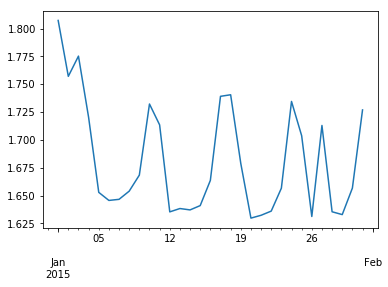

In [15]:
# Plot daily average of passenger count
%matplotlib inline
(df.passenger_count
       .resample('1d')
       .mean()
       .compute()
       .plot())



Note there is a pattern here, it looks to me like there are more passengers over the weekend?

(Run other ad hoc commands if you like, change 1d to 1h for hourly data, or try tip_amount and figure out what happened on the 19th of Jan).

So this is Dask. If you have big datasets you'd like to play with this is definitely worth exploring.

(This demo was based on https://gist.github.com/mrocklin/fa8e30776e82d46015bfe8fd3b35fcb1 )

## Oh no, theory!

<img src="AmdahlsLaw.png" width="50%"/>

Before we wrap up this section, a brief word on the theory that limits how far you can go with parallelization.

Amdahl's Law places a hard limit on how much speedup you can achieve according to how much of your code runs serially. For instance, if only 75% of your code runs in parallel (in terms of execution time), you won't get any significant speedup beyond about about 100 cores. In other words, there's no use throwing 500 cores at the problem -- it won't get any faster!

In practice, we tend to size our problems according to how much computing power we have available. You might have more than you think, as we'll discuss in the next section.

## Wanna get really serious? Use a GPU!

<img src="gpu.png"/>

(aka *G*raphical *P*rocessing *U*nit)

Before wrapping up, I mention this as a super-advanced trick some of you might like to take advantage of someday. I stress this is probably something that most of you will never need, but handy to know about just in case!

GPUs, the things traditionally used to make video games run fast, are very well suited to certain classes of computational problem, and for those cases are much faster than using a CPU alone. You can even buy special general purpose GPUs (GPGPU) that don't actually have a video output; their job is only to run calculations for you.

Roughly speaking, a GPU has hundreds of simple cores running in parallel, communicating via shared memory. So the basic premise is the same as we've discussed, but at a larger scale.

### Options for GPU Programming in Python

PyCuda: https://mathema.tician.de/software/pycuda/

Numba: http://numba.pydata.org/numba-doc/0.13/CUDAJit.html

GPUs need special code to run, usually in a language called CUDA.

We can use CUDA in Python via PyCUDA. We can write CUDA directly inline, or we can use some shortcuts that let us stay in Python.

Numba is another option, and can generate and compile CUDA automatically for us.


### Which technique do I choose?


<blockquote>I have a thousand images to process. Each one takes about 5 minutes, and they don't depend on one another.</blockquote>

Embarassingly Parallel

(Discussion)

So this will take ~3 days. If it's a one off, perhaps we can just tolerate it?

If not, run a few python instances at once, and maybe reduce this by 2-4x? Could use multiprocessing instead for this, if we like.

If we want to get really serious, we could use what's called a job array on a supercomputer, and potentially knock this whole thing over in < an hour!

<blockquote>I've written a simulation of coral growth. It doesn't take long to run, but I need to try it with many different combinations of parameters, which will take ages.</blockquote>

Embarassingly Parallel

(Discussion)

So perhaps we have 5 sets of parameters, with 100 steps each? We could iterate through each in Python, kicking off tasks for each? `multiprocessing` could work for this, as could iPython Parallel if we need more than one computer to finish in a sensible amount of time.

<blockquote>I have a genomics pipeline that includes a step where the data is split into chunks for processing before being recombined.</blockquote>

Multicore (maybe multinode if big enough)




(Discussion)

So we could do this all from the same script in `multiprocessing`. If we need more than one computer however, we might need to look to iPython Parallel or Dask. 

<blockquote>I'm simulating a jet turbine by modelling the physics and chemistry within discrete volumes of space which interact with adjoining volumes over time. The more volumes I can simulate the better!</blockquote>

Multinode

(Discussion)

This is really a classic use-case for MPI, where we might assign hundreds of computers to the job, allowing one CPU for each discrete volume of space. GPUs are increasingly being used for this type of work too (either on a single machine, or also across a cluster).